In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import torch.nn as nn

In [2]:
raw_data = pd.read_csv("./path - 副本.csv", header=0)

# Find out all devices
Scan all paths and find all device types through the "eval" function.

In [3]:
Phone = "Phone"
PC = "PC"
TV = "TV"
Tablet = "Tablet"
Unknown = "Unknown"
Robot = "Robot"

In [4]:
for _ in range(len(raw_data)):
    try: 
        eval(raw_data.loc[_, 'path'])
    except NameError:
        print(raw_data.loc[_, 'path'])

# process raw data
Process raw data for next steps.

In [5]:
def fun(row):
    return [_[1]for _ in eval(row)]

In [6]:
processed = raw_data['path'].apply(fun)

In [7]:
processed_data = pd.concat([processed, raw_data[['impressions', 'cost', 'sales']]], axis=1)

# Try to learn about path data
Use the Counter() function to calculate the number of occurrences of each string

In [8]:
device_list = []
for path in processed_data['path']:
    device_list += path

device_count = Counter(device_list)

for device, count in device_count.items():
    print(f"'{device}' appears {count} times.")

'Phone' appears 254615 times.
'PC' appears 268162 times.
'TV' appears 1233 times.
'Tablet' appears 15945 times.
'Unknown' appears 32 times.
'Robot' appears 3 times.


Compared to 'Phone', 'PC', 'TV' and 'Tablet', I drop "Unknown" and "Robot".

# find Out Notnull Data

In [9]:
notnull = processed_data[processed_data['sales'].notnull()]

In [10]:
notnull.head(10)

,path,impressions,cost,sales
22,"[PC, PC, Phone, Phone, Phone, Phone, Phone, Ph...",384,1.12180,10.26
29,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",180,0.55064,42.40
52,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",378,1.17496,70.28
66,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",360,1.08703,78.71
70,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",5544,14.50251,259.35
76,"[Phone, Phone, PC, PC, Phone]",8960,23.57667,146.65
78,"[PC, PC, PC, Phone, Phone, PC, Phone]",896,2.42499,19.83
159,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",1200,3.38102,74.68
168,"[Phone, Phone, PC, PC, PC, Phone, Phone, Phone...",1359,4.08448,382.86
179,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",22154,58.13893,1936.04


# Build Global Weight Graph

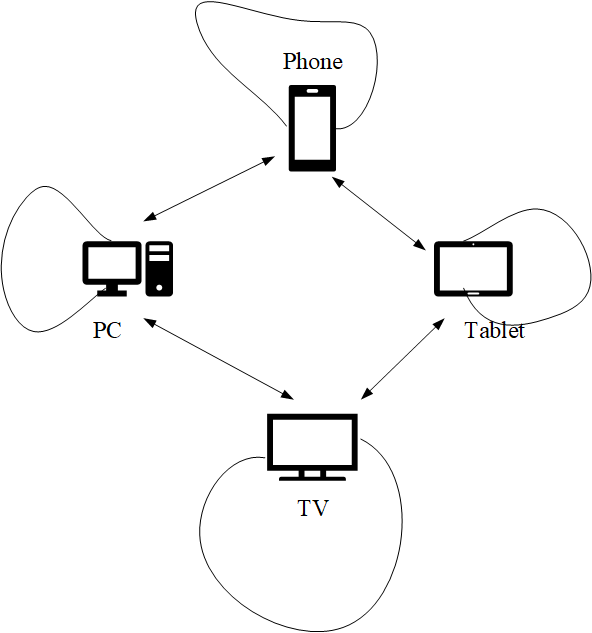

As shown in the picture, we build the global graph through the following steps:
1. Read one path from all paths one by one, for example, ['Phone', 'PC', 'TV', 'Tablet'].
2. Scan the selected path from left to right, if there are no edges between two devices, add an edge to their node and set the weight of this edge as 1/k. K is the distance between the relative positions of these two devices in the selected path. For example, k of (Phone, PC) is 1, k of (Phone, TV) is 2, k of (Phone, Tablet) is 3; k of (PC, TV) is 1, k of (PC, Tablet) is 2; k of (TV, Tablet) is 1.
3. if there is a edge between two devices, revise the weight to "weight + 1/k"


The function of a global graph is to calculate the weight of jumps between different devices.

In [11]:
# G = nx.Graph() # Undirected graphs with self loops
G = nx.DiGraph() # Directed graphs with self loops
nodes = ['Phone', 'PC', 'TV', 'Tablet']
G.add_nodes_from(nodes)

In [12]:
def update_graph(tmp):
    for i in range(len(tmp)):
        for j in range(i+1, len(tmp)):
            x, y = tmp[i], tmp[j]
            if x in ['Unknown', 'Robot'] or y in ['Unknown', 'Robot']:
                continue
            dist = abs(j - i)
            if G.has_edge(x, y):
                G[x][y]['weight'] += 1.0 / dist
            else:
                G.add_edge(x, y, weight=1.0 / dist)

In [13]:
def norm_graph(Graph):
    # 将边的权重进行归一化
    data = []
    for edge in Graph.edges:
        data.append(Graph[edge[0]][edge[1]]['weight'])
    min_value = np.min(data)
    max_value = np.max(data)
    # 归一化数据
    normalized_data = (data - min_value) / (max_value - min_value)
    for i, edge in enumerate(Graph.edges):
        Graph[edge[0]][edge[1]]['weight'] =  normalized_data.tolist()[i]
    return Graph

In [14]:
for _ in range(len(processed_data)): # 全局图
    tmp = processed_data.iloc[_]['path']
    update_graph(tmp)
# G = norm_graph(G)

In [15]:
# 访问节点和边
print('Nodes:', G.nodes)
print('Edges:', G.edges)
for edge in G.edges:
    print(f"{edge[0]}->{edge[1]}: {G[edge[0]][edge[1]]['weight']}")

Nodes: ['Phone', 'PC', 'TV', 'Tablet']
Edges: [('Phone', 'Phone'), ('Phone', 'PC'), ('Phone', 'Tablet'), ('Phone', 'TV'), ('PC', 'PC'), ('PC', 'Phone'), ('PC', 'Tablet'), ('PC', 'TV'), ('TV', 'TV'), ('TV', 'Phone'), ('TV', 'PC'), ('Tablet', 'Tablet'), ('Tablet', 'PC'), ('Tablet', 'Phone'), ('Tablet', 'TV')]
Phone->Phone: 758868.5344321659
Phone->PC: 106112.70489348203
Phone->Tablet: 4677.257512029583
Phone->TV: 91.99173881673882
PC->PC: 749674.1689984788
PC->Phone: 97787.71073565212
PC->Tablet: 3641.1637615032164
PC->TV: 11.950000000000001
TV->TV: 3423.234911820899
TV->Phone: 107.34087301587303
TV->PC: 25.326190476190472
Tablet->Tablet: 33232.01981385865
Tablet->PC: 3244.2430981819175
Tablet->Phone: 3949.7183252263126
Tablet->TV: 1.0


# calculate weight for every path

In [16]:
def cal_weights(test):
    weights = 0.0
    for i in range(len(test)-1):
        x, y = test[i], test[i+1]
        if x in ['Unknown', 'Robot'] or y in ['Unknown', 'Robot']:
            continue
        weights += G[x][y]['weight']
    return weights

In [17]:
add_weights_to_data = notnull['path'].apply(cal_weights)

In [18]:
encoded_data = pd.concat([add_weights_to_data, notnull[['impressions', 'cost', 'sales']]], axis=1)

In [19]:
train_test = encoded_data

In [20]:
train_test.head(5)

,path,impressions,cost,sales
22,2.285465e+07,384,1.12180,10.26
29,2.069335e+07,180,0.55064,42.40
52,1.157773e+07,378,1.17496,70.28
66,9.273545e+06,360,1.08703,78.71
70,1.904760e+08,5544,14.50251,259.35


In [21]:
import numpy as np

corr_matrix = np.corrcoef(train_test.values.T)
print(corr_matrix)

[[ 1.         -0.06320757 -0.06226848 -0.04197209]
 [-0.06320757  1.          0.99707325  0.63581188]
 [-0.06226848  0.99707325  1.          0.65478343]
 [-0.04197209  0.63581188  0.65478343  1.        ]]


In [22]:
train_test[['path', 'impressions', 'cost']]

,path,impressions,cost
22,2.285465e+07,384,1.12180
29,2.069335e+07,180,0.55064
52,1.157773e+07,378,1.17496
66,9.273545e+06,360,1.08703
70,1.904760e+08,5544,14.50251
...,...,...,...
20433,5.463853e+07,51246,142.05175
20454,1.689901e+07,475,1.65165
20456,7.006134e+06,588,1.65842
20459,7.658890e+06,1068,2.84601


In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

X = train_test[['path', 'impressions', 'cost']]
y = train_test['sales'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print("DecisionTreeRegressor R2 score: {:.6f}".format(score))
score = mean_absolute_error(y_test, y_pred)
print("DecisionTreeRegressor MAE score: {:.6f}".format(score))
score = mean_squared_error(y_test, y_pred)
print("DecisionTreeRegressor MSE score: {:.6f}".format(score))

# 创建随机森林回归器对象
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# 使用训练集训练模型
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
print("RandomForestRegressor R2 score: {:.6f}".format(score))
score = mean_absolute_error(y_test, y_pred)
print("RandomForestRegressor MAE score: {:.6f}".format(score))
score = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor MSE score: {:.6f}".format(score))

DecisionTreeRegressor R2 score: 0.946723
DecisionTreeRegressor MAE score: 161.732680
DecisionTreeRegressor MSE score: 135941.945116
RandomForestRegressor R2 score: 0.967057
RandomForestRegressor MAE score: 130.889527
RandomForestRegressor MSE score: 84058.444086


In [24]:
# from sklearn.model_selection import GridSearchCV
# svr = SVR()

# param_grid={
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#             'C': [1.0, 5.4],
#             'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 2],
#             'gamma': [0.0001, 0.001, 0.01, 0.1]
#         }

# grid = GridSearchCV(
# estimator=svr,
#         param_grid=param_grid,
#         cv=3, scoring='r2', verbose=3, n_jobs=-1)

# grid.fit(X_train,y_train)


# #print the best parameters from all possible combinations
# print("best parameters are: ", grid.best_params_)
# new_svr = grid.best_estimator_ 
# y_pred = new_svr.predict(X_test)
# score = r2_score(y_test, y_pred)
# print("new_SVR R2 score: {:.6f}".format(score))

# Generate pseudo label for null

In [25]:
null_ = processed_data[processed_data['sales'].isnull()]

In [26]:
null_.head(5)

,path,impressions,cost,sales
0,"[Phone, Phone, Phone, Phone, Phone, Phone, Pho...",90,0.26882,NaN
1,"[PC, PC, PC, PC, PC, PC, PC, PC, PC, PC, PC, P...",180,0.47130,NaN
2,"[Phone, PC, PC, Phone, PC, PC, PC, PC, PC, PC,...",36,0.10622,NaN
3,"[PC, PC, Phone, PC, Phone, PC, PC, PC, PC, PC,...",60,0.14821,NaN
4,"[PC, Phone, Phone, Phone, PC, PC, PC, PC, PC, ...",36,0.10069,NaN


In [27]:
convert_ = null_['path'].apply(cal_weights)

In [28]:
convert_data = pd.concat([convert_, null_[['impressions', 'cost']]], axis=1)

In [29]:
convert_data['sales'] = model.predict(convert_data)

In [30]:
convert_data.head(10)

,path,impressions,cost,sales
0,2.066577e+07,90,0.26882,148.47
1,3.169022e+07,180,0.47130,29.63
2,1.015357e+07,36,0.10622,11.46
3,1.914966e+07,60,0.14821,11.64
4,5.683103e+06,36,0.10069,47.04
5,9.315298e+06,32,0.05849,11.59
6,8.630853e+06,30,0.09980,12.99
7,9.440668e+06,34,0.07915,9.42
8,1.689901e+07,450,1.41547,177.82
9,6.441972e+06,39,0.11653,24.86


# Use ALL Data

In [31]:
combined_df = pd.concat([convert_data, encoded_data], ignore_index=True)
print(combined_df.head(10))

           path  impressions     cost   sales
0  2.066577e+07           90  0.26882  148.47
1  3.169022e+07          180  0.47130   29.63
2  1.015357e+07           36  0.10622   11.46
3  1.914966e+07           60  0.14821   11.64
4  5.683103e+06           36  0.10069   47.04
5  9.315298e+06           32  0.05849   11.59
6  8.630853e+06           30  0.09980   12.99
7  9.440668e+06           34  0.07915    9.42
8  1.689901e+07          450  1.41547  177.82
9  6.441972e+06           39  0.11653   24.86


In [32]:
combined_df = combined_df.sample(frac=1, random_state=42)
print(combined_df.head(10))

               path  impressions     cost   sales
17234  2.141544e+07           62  0.27239  148.47
10257  7.978097e+06           30  0.10318   12.99
19466  7.792586e+06         1651  5.07538   62.70
12368  5.422142e+06           30  0.09339   47.04
960    6.512176e+06           28  0.07925   47.04
13911  1.240259e+07           63  0.19956   21.57
7348   4.290737e+06           22  0.07389   47.04
4702   1.616015e+07           52  0.11978   11.64
15176  7.200840e+06           28  0.09709   45.42
15793  1.232319e+07           60  0.13200   21.57


In [33]:
X = combined_df[['path', 'impressions', 'cost']]
y = combined_df['sales'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print("DecisionTreeRegressor R2 score: {:.6f}".format(score))
score = mean_absolute_error(y_test, y_pred)
print("DecisionTreeRegressor MAE score: {:.6f}".format(score))
score = mean_squared_error(y_test, y_pred)
print("DecisionTreeRegressor MSE score: {:.6f}".format(score))


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
print("RandomForestRegressor R2 score: {:.6f}".format(score))
score = mean_absolute_error(y_test, y_pred)
print("RandomForestRegressor MAE score: {:.6f}".format(score))
score = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor MSE score: {:.6f}".format(score))

DecisionTreeRegressor R2 score: 0.924883
DecisionTreeRegressor MAE score: 12.072347
DecisionTreeRegressor MSE score: 7917.808732
RandomForestRegressor R2 score: 0.950680
RandomForestRegressor MAE score: 9.974221
RandomForestRegressor MSE score: 5198.611499


In [34]:
# from sklearn.model_selection import GridSearchCV
# RF = RandomForestRegressor(random_state=42)

# param_grid={
#     'n_estimators': [10, 20, 50, 80, 100, 200, 500, 1000],
#             'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4]
#         }

# grid = GridSearchCV(
# estimator=RF,
#         param_grid=param_grid,
#         cv=3, scoring='r2', verbose=3, n_jobs=-1)

# grid.fit(X_train,y_train)


# #print the best parameters from all possible combinations
# print("best parameters are: ", grid.best_params_)
# best = grid.best_estimator_ 
# y_pred = best.predict(X_test)
# score = r2_score(y_test, y_pred)
# print("new R2 score: {:.6f}".format(score))